<a href="https://colab.research.google.com/github/bosilr/NLP_project/blob/main/analiza2_flairNER_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -----------------------------------------------------------
# Faza 2:
# Implementacija flair NER
# -----------------------------------------------------------

#Uvažanje potrebnih knjižnjic
!pip install flair
!pip install afinn
!pip install vaderSentiment
!pip install spacy


import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('gutenberg')
import re
import string
from itertools import combinations
from collections import Counter


import itertools
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

from nltk.tokenize import sent_tokenize
from tqdm import tqdm
from flair.models import SequenceTagger
from flair.data import Sentence
import operator

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [2]:
#Prenašanje datotek in knjižnjic iz driva

from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/Kode/NLP_project.zip -d /content
!cp /content/code/sentimentAnalysis.py /content
from sentimentAnalysis import vaderSentiment, afinnSentiment, textblobSentiment

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/Kode/NLP_project.zip
replace /content/analysis/.ipynb_checkpoints/ner-checkpoint.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
# Use flair named entity recognition
tagger = SequenceTagger.load('ner')     # ner, ner-ontonotes, ...

2022-05-21 08:06:28,388 loading file /root/.flair/models/ner-english/4f4cdab26f24cb98b732b389e6cebc646c36f54cfd6e0b7d3b90b25656e4262f.8baa8ae8795f4df80b28e7f7b61d788ecbb057d1dc85aacb316f1bd02837a4a4
2022-05-21 08:06:31,067 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [4]:
def read_text(path):
    with open(path, encoding="utf-8") as f:
        text = f.read()
        text = text.replace('\r', ' ').replace('\n', ' ')\
            .replace("’", "'").replace("\"", "").replace("”", "").replace("“", "")
    return text

def flair_NER(book):
    """
    flair_NER vrne seznam, v katerem so shranjene prepoznane identitete glede na posamezni stavek
    :param book: str
    :return: entity_dict (seznam slovarjev kot npr. [name, tag, start_pos, stop_pos, line_num. token_num])
    """

    # 00 Pretvori knjigo v stavke:
    sent = sent_tokenize(book)

    # 01 NER model
    entity_dict = []
    for line_num, line in enumerate(tqdm(sent)):

        # 01a Predict:
        sentence = Sentence(line)
        tagger.predict(sentence)

        # 01b Vmesni izpis (brez lokacije):
        #print(sentence.to_tagged_string())
        #print(sentence.get_spans('ner'))

        # 01c Ekstrakcija podatka iz stavka:
        for entity in sentence.get_spans('ner'):        # veliko različnih flair - nerov
            name = entity.text

            # str location
            # start_pos = entity.start_position    # št. str
            # stop_pos = entity.end_position      # št. str

            # token location
            tmp_flag = True
            for token in entity:
                if tmp_flag:
                    start_pos = token.idx -1
                    stop_pos = token.idx
                else:
                    stop_pos = token.idx
                tmp_flag = False

            tag = entity.get_label("ner").value             # tag = entity.tag
            conf_score = entity.get_label("ner").score      # conf_score = entity.score

            info_dict = {}
            info_dict["name"] = name
            info_dict["tag"] = tag
            info_dict["start_pos"] = start_pos
            info_dict["stop_pos"] = stop_pos
            info_dict["line_num"] = line_num

            entity_dict.append(info_dict)

    return entity_dict

def get_names_from_NER(entity_dict):
    """
    get_names_from_NER sprejme entity_dict in vrne urejen seznam terk ("ime", št_zaznano)
    :param entity_dict: dict (seznam dictov)
    :return: unique_names: list
    """
    unique_names = {}

    for entity in entity_dict:
        if entity["tag"] == "PER":
            if entity["name"] not in unique_names:
                unique_names[entity["name"]] = 1
            else:
                unique_names[entity["name"]] += 1
    unique_names = sorted(unique_names.items(), key=operator.itemgetter(1),reverse=True)

    return unique_names

In [5]:
def get_named_entities(sentences):
    threshold = 0.0001
    named_entities = []
    named_entities_thresholded = []
    for s in sentences:
        named_entities += NER(s)

    named_entities = [ne for ne in named_entities if ne not in common_english_words]
    named_entities = Counter(named_entities)
    for ne in named_entities:
        if named_entities[ne] >= threshold * len(sentences):
            named_entities_thresholded.append(ne)

    return named_entities_thresholded

In [33]:
def get_main_characters(book, characters, number_of_characters):
    cv = CountVectorizer(vocabulary=characters, stop_words='english')
    freq = cv.fit_transform([book.lower()])
    freq = pd.DataFrame(freq.toarray(), columns=cv.get_feature_names())
    freq = freq.T
    freq = freq.sort_values(by=0, ascending=False)
    freq = freq[0:number_of_characters]

    characters = list(freq.index)
    print(freq)
    print(characters)
    return freq, characters

In [42]:
def plot_graph(name_list, name_frequency, matrix, plt_name, mode, path=''):
    print(name_list)
    label = {i: i for i in name_list}
    edge_list = []
    shape = matrix.shape[0]
    triangle = list(zip(*np.where(np.triu(np.ones([shape, shape])) == 0)))
    normalized_matrix = matrix / np.max(np.abs(matrix))
    normalized_frequency = np.array(name_frequency) / np.max(name_frequency)
    weight = np.log(np.abs(1000 * normalized_matrix) + 1) * 0.7
    print(weight)
    color = 2000 * normalized_matrix
    for i in triangle:
        edge_list.append((name_list[i[0]], name_list[i[1]], {'weight': weight[i], 'color': color[i]}))
    plt.figure(figsize=(12, 12))
    G = nx.Graph()
    G.add_nodes_from(name_list)
    G.add_edges_from(edge_list)
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    colors = [G[u][v]['color'] for u, v in edges]

    
    nx.draw_circular(G, node_color='#A0CBE2', node_size=normalized_frequency * 2000,
            linewidths=10, labels=label, edge_color=colors, with_labels=True,
            width=weights, edge_vmin=-1000, edge_vmax=1000)


    plt.savefig(path + plt_name + '.png')

In [46]:
book = read_text('/content/data/books/ASongOfIceAndFire/AGOT/GoT1_short.txt')
sentences = nltk.sent_tokenize(book)
entity_dict = flair_NER(book)
characters = get_names_from_NER(entity_dict)
main_characters = [c[0].lower() for c in characters if c[1] > 3]
freq = [c[1] for c in characters if c[1] > 3]
#freq, main_characters = get_main_characters(book, characters, number_of_characters=25)
sentiment_mtx, _ = afinnSentiment(sentences, main_characters)

['jon', 'bran', 'ned', 'arya', 'catelyn', 'sansa', 'robert', 'robb', 'tyrion', 'joffrey', 'dany', 'will', 'maester luwin', 'illyrio', 'ser rodrik', 'lannister', 'gared', 'stark', 'tyrion lannister', 'lady', 'jaime', 'viserys', 'khal drogo', 'jory', 'septa mordane', 'jon snow', 'benjen stark', 'myrcella', 'nymeria', 'royce', 'eddard stark', 'starks', 'drogo', 'varys', 'ser waymar', 'theon greyjoy', 'winterfell', 'magister illyrio', 'brandon', 'ghost', 'grenn', 'dothraki', 'littlefinger', 'mycah', 'rickon', 'cersei', 'daenerys', 'lady stark', 'lysa', 'moreo', 'father', 'greyjoy', 'rhaegar', 'mother', 'ser alliser', 'benjen', 'hand', 'yoren', 'ser waymar royce', 'eddard', 'petyr', 'toad', 'old nan', 'lyanna', 'lannisters', 'mormont', 'gods', 'hullen', 'jon arryn', 'ser jorah', 'sandor clegane', 'cersei lannister', 'tommen', 'wall', 'snow', 'robert baratheon', 'usurper', 'your grace', 'uncle benjen', 'aerys', 'hound', 'lord snow', 'theon', 'jorah mormont', 'aerys targaryen', 'joff', 'luwin

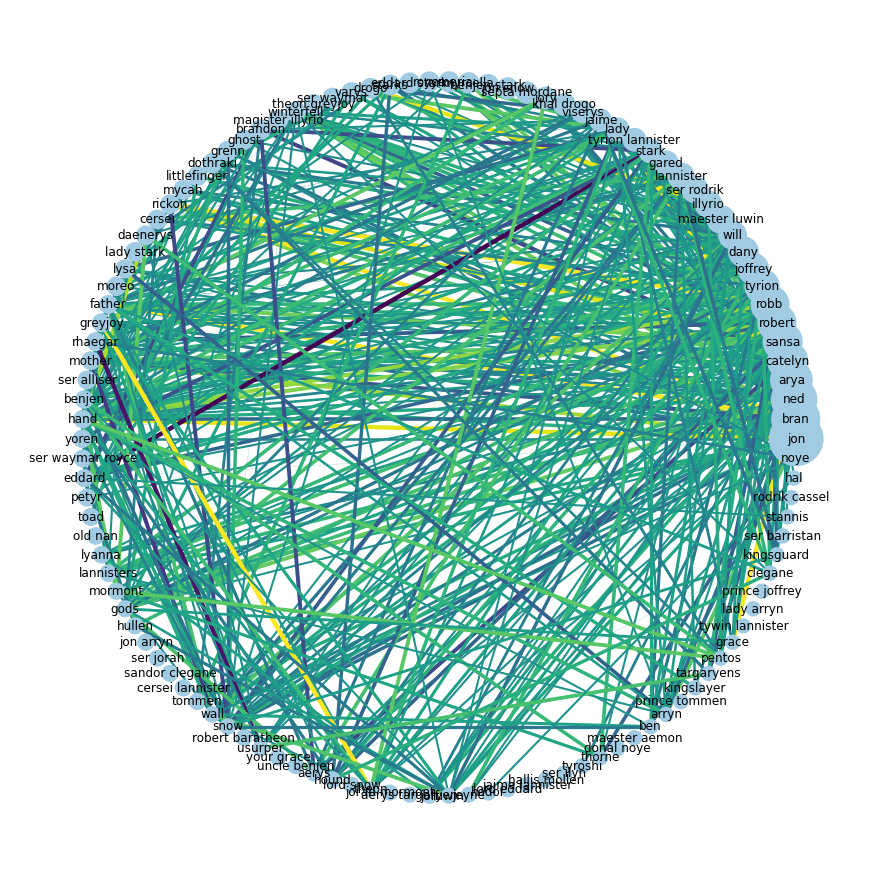

In [47]:
plot_graph(main_characters, freq, sentiment_mtx, "test" + ' sentiment graph', 'sentiment')